In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import re
import matplotlib.dates as mdates

import textwrap
from iso4 import abbreviate

In [2]:
%%time
works = pd.read_csv('../data/openalex_articles_230328.csv')

CPU times: total: 1min 35s
Wall time: 1min 36s


In [3]:
%%time
groupby_venue_year = works.groupby(['source_id', 'year']).count()

CPU times: total: 48.3 s
Wall time: 48.5 s


In [4]:
groupby_venue_year = groupby_venue_year.reset_index().pivot(index='year', columns='source_id', values='type').fillna(0.0)

In [5]:
groupby_venue_year = groupby_venue_year.loc[np.arange(1970,2023)]

In [6]:
%%time
paper_mill_df = pd.read_csv('../data/paper_mill_dois_240418.csv')

CPU times: total: 15.6 ms
Wall time: 36 ms


In [7]:
paper_mill_dois = ['https://doi.org/' + x for x in paper_mill_df['doi'].astype(str).str.lower().values]

In [8]:
%%time
paper_mill_works = openalex.works(
            dataset = 'main', 
            filters={'doi': paper_mill_dois})

CPU times: total: 2min 41s
Wall time: 2min 55s


In [9]:
%%time
groupby_venue_year_ppm = paper_mill_works.groupby(['source_id', 'year']).count()

CPU times: total: 31.2 ms
Wall time: 31 ms


In [10]:
groupby_venue_year_ppm = groupby_venue_year_ppm.reset_index().pivot(index='year', columns='source_id', values='type').fillna(0.0)

In [11]:
# book series, preprint servers

exclude = ['S4210179954', 'S4306463075', 'S4210169156', 'S2764905038', 
           'S4306463230', 'S4306463941', 'S4306463949', 'S4210172589', 
           'S4210216571']

In [12]:
interest_list = paper_mill_works[~paper_mill_works['source_id'].isin(exclude)]['source_id'].value_counts().head(50).index

In [13]:
venues_counts = openalex.sources('by_year').rename(columns={'source_id': 'venue_id'})

In [14]:
sources = openalex.sources()
sources = sources.set_index('source_id')

In [15]:
n_paper_mills_dict = paper_mill_works.drop_duplicates('work_id').groupby('source_id').count()['work_id'].to_dict()

In [16]:
# correcting counts of scientific reports
groupby_venue_year.loc[2014, 'S196734849'] = 4021
groupby_venue_year.loc[2015, 'S196734849'] = 10941

meta NOT subset; don't know how to subset; dropped


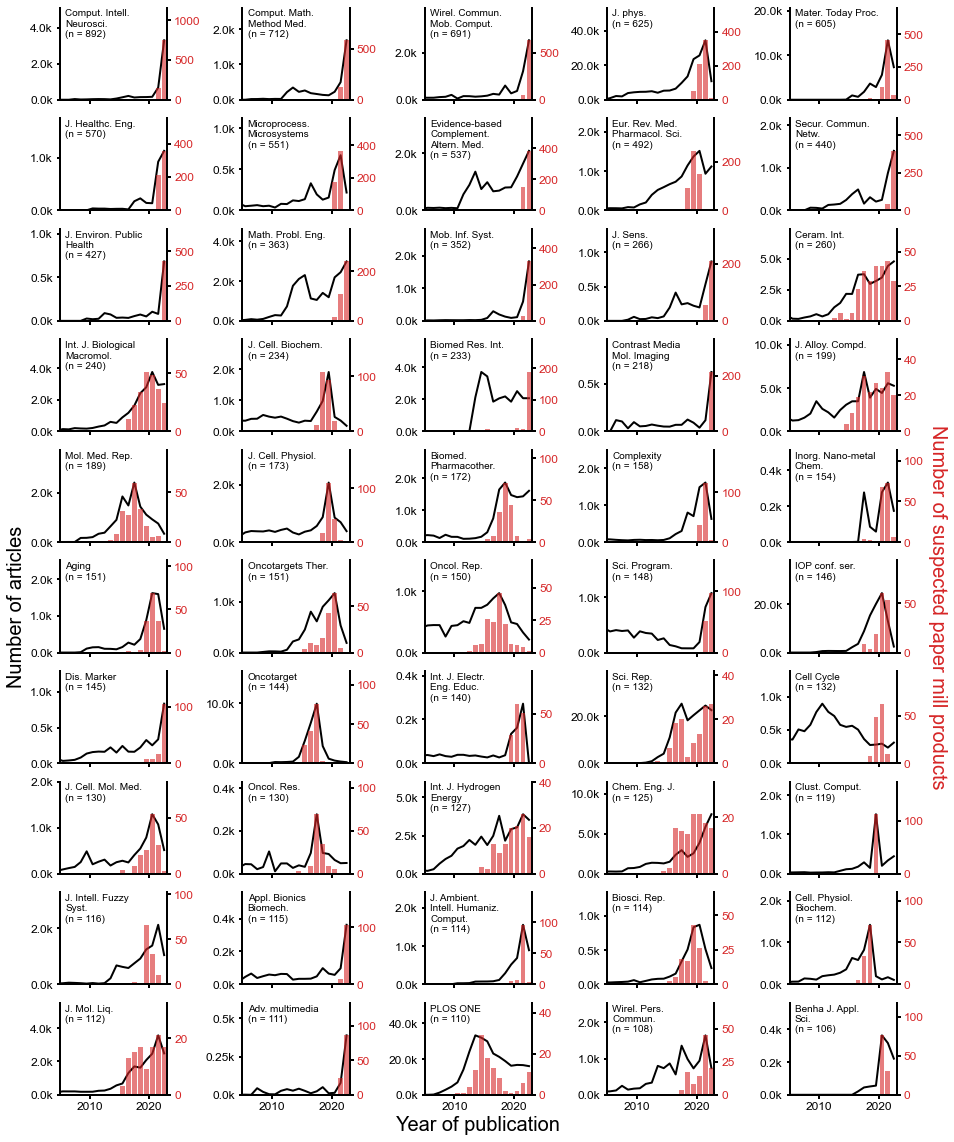

In [27]:
linewidth=2
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,20), gridspec_kw={'hspace':0.2, 'wspace':0.7})

wrapper = textwrap.TextWrapper(width=18)

twin_ax_array = []

for source_id, ax in zip(interest_list, axes.flatten()):
    if source_id in groupby_venue_year.columns:
        ax.plot(groupby_venue_year.index+0.5, groupby_venue_year[source_id], color='k', linewidth=2, label='Articles')
        max_count = groupby_venue_year[source_id].max()
    elif source_id in venues_counts.columns:
        ax.plot(venues_counts.index+0.5, venues_counts[source_id], color='r', linewidth=2, alpha=0.5, label='All items')
        max_count = venues_counts[source_id].max()
    
    ax.set_xlim([2005, 2023])
    ax.set_ylim(bottom=0, top=max_count*1.55)
        
    #ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
    ax.tick_params(labelsize=12, axis='both', width=linewidth)

    n_paper_mills = n_paper_mills_dict.get(source_id)
    
    display_name = sources.loc[source_id]['display_name']
    if len(display_name) > 10:
        ax.set_title(wrapper.fill(abbreviate(display_name)) + '\n(n = ' + \
                              str(n_paper_mills) + ')', loc='left', x=0.05, y=0.92, va='top', 
                     fontsize=10)
    else:
        ax.set_title(wrapper.fill(display_name) + '\n(n = ' + \
                              str(n_paper_mills) + ')', loc='left', x=0.05, y=0.92, va='top', 
                     fontsize=10)   
        
    ax.set_xticks([2010, 2020])
    ax.set_xticklabels([])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
    #ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
    #ax.set_yticklabels(ylabels)
    
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: str(float(x/1000)) + 'k'))
    
    
    ax = ax.twinx()
    if source_id in groupby_venue_year_ppm.columns:
        ax.bar(x=groupby_venue_year_ppm.index+0.5, 
                   height=groupby_venue_year_ppm[source_id], color=sns.color_palette()[3], alpha=0.6)
        top_ylim = groupby_venue_year_ppm[source_id].max()*1.55
    else:
        top_ylim = 10
        yticks = [0,5,10]
        ax.set_yticks(yticks)
    ax.set_ylim([0, top_ylim])
    twin_ax_array.append(ax)
    
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
    ax.tick_params(labelsize=12, axis='both', width=linewidth)
    ax.tick_params(axis='y', labelcolor=sns.color_palette()[3])
    '''
    ax.vlines(sources.loc[source_id]['wos_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    ax.vlines(sources.loc[source_id]['scopus_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    ax.vlines(sources.loc[source_id]['pubmed_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    
axes[0][4].plot([], [], color='darkblue', linestyle='dashed', linewidth=linewidth, label='deindexed by WoS')
axes[0][4].plot([], [], color='darkorange', linestyle='dashed', linewidth=linewidth, label='deindexed by Scopus')
axes[0][4].plot([], [], color='purple', linestyle='dashed', linewidth=linewidth, label='deindexed by MEDLINE')
    '''
    
#axes[0][4].legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False)
axes[5][0].set_ylabel(r'Number of articles', fontsize=20, ha='center')
axes[9][2].set_xlabel('Year of publication', fontsize=20)
twin_ax_array[29].set_ylabel('Number of suspected paper mill products', fontsize=20, 
                            color=sns.color_palette()[3], rotation=-90, labelpad=30)

for ax in axes[9, :]:
    ax.set_xticks([2010, 2020])
    ax.set_xticklabels([2010,2020])

#fig.tight_layout()

plt.savefig('../img/largest_paper_mill_journals_240430.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/largest_paper_mill_journals_240430.pdf', bbox_inches='tight')

In [28]:
# indexing
sources_index = pd.read_csv('../data/sources_scopus_wos_indexing_240418.csv').set_index('source_id')

In [52]:
#CAS EWL
collect = []
for year in ['2020', '2021', '2023', '2024']:
    ewl = pd.read_csv('../data/240612_cas_ewl_' + year + '.csv', header=1)
    ewl['year'] = year
    collect.append(ewl)
ewl = pd.concat(collect)

In [61]:
ewl.loc[ewl['Journal Title'] == 'Aging-US', 'Journal Title'] = 'Aging'

In [62]:
ewl['display_name_lower'] = ewl['Journal Title'].str.lower()

In [64]:
sources_index['display_name_lower'] = sources_index['display_name'].str.lower()

In [72]:
ewl_years = pd.merge(sources_index.reset_index(), ewl).groupby('source_id')['year'].apply(list).apply(lambda x: ', '.join(x))

In [74]:
sources_index['ewl_years'] = ewl_years

In [78]:
ewl_years

nan

meta NOT subset; don't know how to subset; dropped


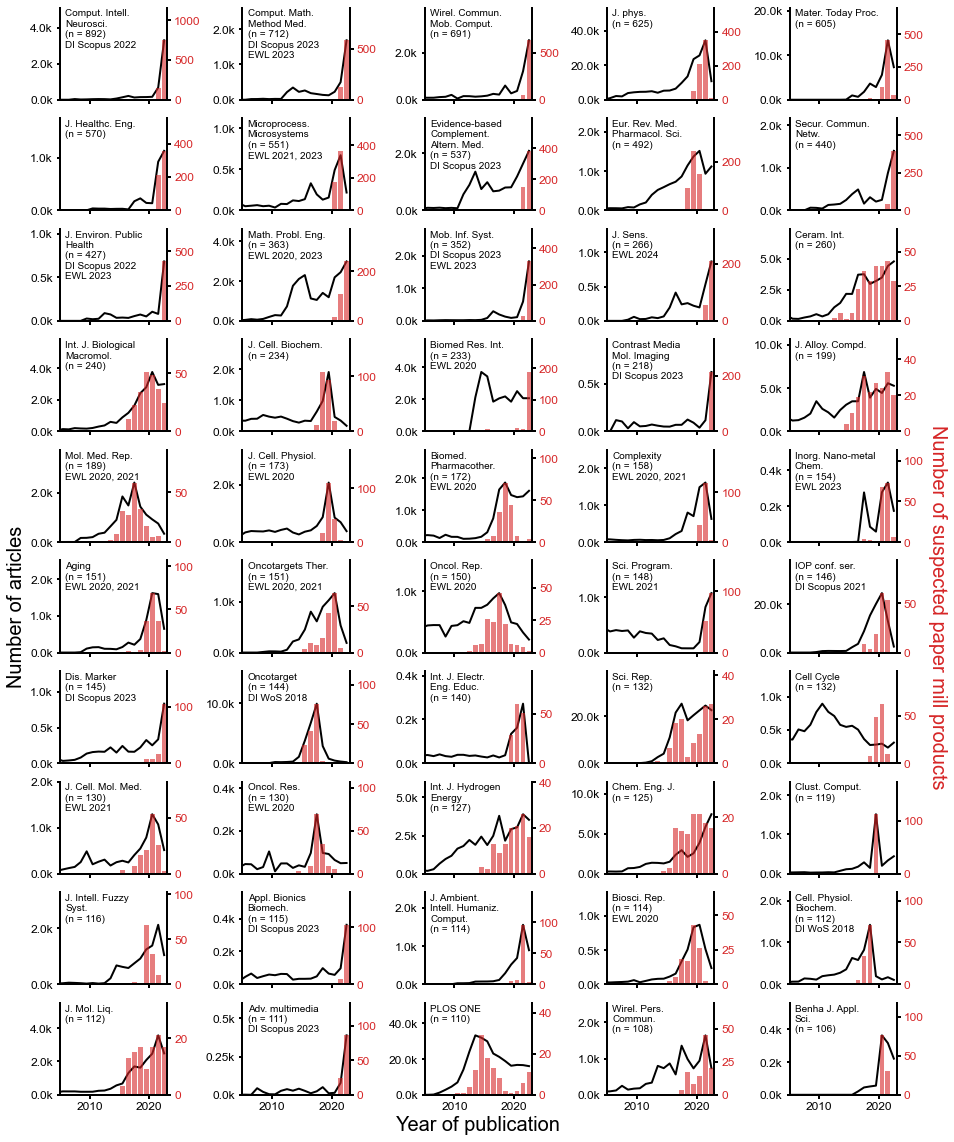

In [79]:
linewidth=2
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,20), gridspec_kw={'hspace':0.2, 'wspace':0.7})

wrapper = textwrap.TextWrapper(width=18)

twin_ax_array = []

for source_id, ax in zip(interest_list, axes.flatten()):
    if source_id in groupby_venue_year.columns:
        ax.plot(groupby_venue_year.index+0.5, groupby_venue_year[source_id], color='k', linewidth=2, label='Articles')
        max_count = groupby_venue_year[source_id].max()
    elif source_id in venues_counts.columns:
        ax.plot(venues_counts.index+0.5, venues_counts[source_id], color='r', linewidth=2, alpha=0.5, label='All items')
        max_count = venues_counts[source_id].max()
    
    ax.set_xlim([2005, 2023])
    ax.set_ylim(bottom=0, top=max_count*1.55)
        
    #ax.set_yscale('log')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
    ax.tick_params(labelsize=12, axis='both', width=linewidth)

    n_paper_mills = n_paper_mills_dict.get(source_id)
    
    display_name = sources.loc[source_id]['display_name']
    
    # addendum (deindexing and EWL)
    addendum = ''
    scopus_last_year = sources_index.loc[source_id]['scopus_last_year']
    wos_last_year = sources_index.loc[source_id]['wos_last_year']
    ewl_years = sources_index.loc[source_id]['ewl_years']
    if scopus_last_year > 1900:
        addendum += '\nDI Scopus ' + str(int(scopus_last_year))
    if wos_last_year > 1900:
        addendum += '\nDI WoS ' + str(int(wos_last_year))
    if str(ewl_years) != 'nan':
        addendum += '\nEWL ' + ewl_years
    
    if len(display_name) > 10:
        ax.set_title(wrapper.fill(abbreviate(display_name)) + '\n(n = ' + \
                              str(n_paper_mills) + ')' + addendum, loc='left', x=0.05, y=0.92, va='top', 
                     fontsize=10)
    else:
        ax.set_title(wrapper.fill(display_name) + '\n(n = ' + \
                              str(n_paper_mills) + ')' + addendum, loc='left', x=0.05, y=0.92, va='top', 
                     fontsize=10)   
        
    ax.set_xticks([2010, 2020])
    ax.set_xticklabels([])
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])
    #ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
    #ax.set_yticklabels(ylabels)
    
    ax.get_yaxis().set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: str(float(x/1000)) + 'k'))
    
    
    ax = ax.twinx()
    if source_id in groupby_venue_year_ppm.columns:
        ax.bar(x=groupby_venue_year_ppm.index+0.5, 
                   height=groupby_venue_year_ppm[source_id], color=sns.color_palette()[3], alpha=0.6)
        top_ylim = groupby_venue_year_ppm[source_id].max()*1.55
    else:
        top_ylim = 10
        yticks = [0,5,10]
        ax.set_yticks(yticks)
    ax.set_ylim([0, top_ylim])
    twin_ax_array.append(ax)
    
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(linewidth) for i in ax.spines]
    ax.tick_params(labelsize=12, axis='both', width=linewidth)
    ax.tick_params(axis='y', labelcolor=sns.color_palette()[3])
    '''
    ax.vlines(sources.loc[source_id]['wos_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    ax.vlines(sources.loc[source_id]['scopus_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    ax.vlines(sources.loc[source_id]['pubmed_last_year'], ymin=0, 
              ymax=max_count*1.2, color='k', linestyle='dashed', linewidth=linewidth)
    
axes[0][4].plot([], [], color='darkblue', linestyle='dashed', linewidth=linewidth, label='deindexed by WoS')
axes[0][4].plot([], [], color='darkorange', linestyle='dashed', linewidth=linewidth, label='deindexed by Scopus')
axes[0][4].plot([], [], color='purple', linestyle='dashed', linewidth=linewidth, label='deindexed by MEDLINE')
    '''
    
#axes[0][4].legend(fontsize=16, bbox_to_anchor=(1,1), frameon=False)
axes[5][0].set_ylabel(r'Number of articles', fontsize=20, ha='center')
axes[9][2].set_xlabel('Year of publication', fontsize=20)
twin_ax_array[29].set_ylabel('Number of suspected paper mill products', fontsize=20, 
                            color=sns.color_palette()[3], rotation=-90, labelpad=30)

for ax in axes[9, :]:
    ax.set_xticks([2010, 2020])
    ax.set_xticklabels([2010,2020])

#fig.tight_layout()

plt.savefig('../img/largest_paper_mill_journals_240612.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/largest_paper_mill_journals_240612.pdf', bbox_inches='tight')

In [38]:
if sources_index.loc[source_id]['scopus_last_year'] > 1900:
    print('hehe')

In [39]:
sources_index

,display_name,scopus,scopus_last_year,wos,wos_last_year,pubmed,pubmed_last_year,issn_openalex,issn_l_openalex
source_id,,,,,,,,,
S100000117,Progress in Psychobiology and Physiological Ps...,True,NaN,True,1983.0,False,NaN,[None],[None]
S1000025471,Uluslararasi Iliskiler-international Relations,False,NaN,True,NaN,False,NaN,[None],[None]
S1000112711,Münster Journal of Mathematics,False,NaN,True,NaN,False,NaN,['1867-5778'],['1867-5778']
S100014387,Journal of Proteomics,True,NaN,True,NaN,True,NaN,"['1874-3919', '1874-3919', '1876-7737', '1876-...","['1874-3919', '1876-7737', '1874-3919', '1876-..."
S100014455,BMC Research Notes,True,NaN,True,NaN,True,NaN,['1756-0500'],['1756-0500']
...,...,...,...,...,...,...,...,...,...
S9998669,Annals of Tropical Medicine and Public Health,True,2020.0,True,2017.0,False,NaN,"['1755-6783', '1755-6783', '0974-6005', '0974-...","['1755-6783', '0974-6005', '1755-6783', '0974-..."
S99987044,Journal of Science Teacher Education,True,NaN,True,NaN,False,NaN,"['1573-1847', '1573-1847', '1046-560X', '1046-...","['1573-1847', '1046-560X', '1573-1847', '1046-..."
S99990550,Journal of Consumer Policy,True,NaN,True,NaN,False,NaN,"['0168-7034', '0168-7034', '1573-0700', '1573-...","['0168-7034', '1573-0700', '0168-7034', '1573-..."
